<a href="https://colab.research.google.com/github/MauriCarbon/sms_text_classification/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2025-12-05 00:08:02.292082: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 00:08:02.298850: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-05 00:08:02.370898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-05 00:08:02.370937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-05 00:08:02.372475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0


In [2]:
# get data files
import urllib.request
import os

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

# Download files if they don't exist
if not os.path.exists(train_file_path):
    urllib.request.urlretrieve('https://cdn.freecodecamp.org/project-data/sms/train-data.tsv', train_file_path)
if not os.path.exists(test_file_path):
    urllib.request.urlretrieve('https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv', test_file_path)

print("Data files ready!")

Data files ready!


In [3]:
# Load the data
train_data = pd.read_csv(train_file_path, sep='\t', header=None, names=['label', 'message'])
test_data = pd.read_csv(test_file_path, sep='\t', header=None, names=['label', 'message'])

# Display data info
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nLabel distribution in training data:")
print(train_data['label'].value_counts())
print("\nSample data:")
train_data.head()

Training data shape: (4179, 2)
Test data shape: (1392, 2)

Label distribution in training data:
label
ham     3619
spam     560
Name: count, dtype: int64

Sample data:


,label,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [4]:
# Convert labels to binary (ham=0, spam=1)
train_data['label_num'] = train_data['label'].map({'ham': 0, 'spam': 1})
test_data['label_num'] = test_data['label'].map({'ham': 0, 'spam': 1})

# Prepare training and test sets
train_messages = train_data['message'].values
train_labels = train_data['label_num'].values
test_messages = test_data['message'].values
test_labels = test_data['label_num'].values

print("Training samples:", len(train_messages))
print("Test samples:", len(test_messages))

Training samples: 4179
Test samples: 1392


In [5]:
# Create TextVectorization layer
max_features = 10000
sequence_length = 100

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Adapt the vectorization layer to the training data
vectorize_layer.adapt(train_messages)

print("Vocabulary size:", len(vectorize_layer.get_vocabulary()))

Vocabulary size: 8181


In [6]:
# Build the model
embedding_dim = 64

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(max_features + 1, embedding_dim),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 64)           640064    
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [7]:
# Train the model
history = model.fit(
    train_messages,
    train_labels,
    epochs=15,
    batch_size=32,
    validation_data=(test_messages, test_labels),
    verbose=1
)

# Evaluate on test data
loss, accuracy = model.evaluate(test_messages, test_labels)
print(f"\nTest accuracy: {accuracy:.4f}")

Epoch 1/15
131/131 [==============================] - 2s 8ms/step - loss: 0.4436 - accuracy: 0.8519 - val_loss: 0.3569 - val_accuracy: 0.8657
Epoch 2/15
131/131 [==============================] - 1s 6ms/step - loss: 0.3424 - accuracy: 0.8660 - val_loss: 0.3094 - val_accuracy: 0.8657
Epoch 3/15
131/131 [==============================] - 1s 6ms/step - loss: 0.2559 - accuracy: 0.8782 - val_loss: 0.1867 - val_accuracy: 0.9274
Epoch 4/15
131/131 [==============================] - 1s 7ms/step - loss: 0.1249 - accuracy: 0.9610 - val_loss: 0.0875 - val_accuracy: 0.9734
Epoch 5/15
131/131 [==============================] - 1s 7ms/step - loss: 0.0686 - accuracy: 0.9816 - val_loss: 0.0669 - val_accuracy: 0.9784
Epoch 6/15
131/131 [==============================] - 1s 7ms/step - loss: 0.0479 - accuracy: 0.9880 - val_loss: 0.0580 - val_accuracy: 0.9777
Epoch 7/15
131/131 [==============================] - 1s 9ms/step - loss: 0.0378 - accuracy: 0.9899 - val_loss: 0.0538 - val_accuracy: 0.9813
Epoch 

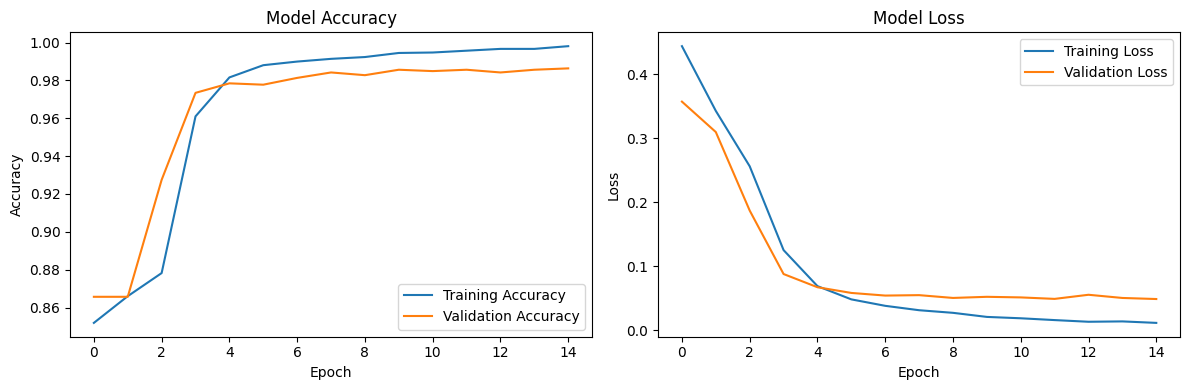

In [8]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [9]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    # Make prediction
    pred = model.predict([pred_text], verbose=0)[0][0]
    
    # Determine label based on probability
    # pred close to 0 = ham, pred close to 1 = spam
    label = 'spam' if pred >= 0.5 else 'ham'
    
    prediction = [float(pred), label]
    return prediction

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.0013368267100304365, 'ham']


In [10]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
